**Example script for direct access of 1 file in hdf5 format (geostationary) and produce a simple map**

**Assumes that the Data server has been mapped as a network drive or the file has been downloaded**

**See https://gitlab.com/helpdesk.landsaf/lsasaf_data_access/-/wikis/data/webdav for details**

To run this example you will need the following packages: xarray, matplotlib and cartopy. Can be installed via conda with
```shell
conda install -c conda-forge h5py matplotlib cartopy 
```

We **recomend** this approach, using map network drive in windows to **load/process large amounts of data**.


In [1]:
# Required package to load data 
import h5py
import numpy as np
import os 
import datetime as dt

# Required packages for ploting 
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.feature.nightshade import Nightshade

In [2]:
# open the hdf5 file with h5py
# Assuming the WebDAV was maped into drive "Z:\" / or replace with local drive if file was downloaded
# use os.path.join to avoid windows/linux problems
slot=dt.datetime(2021,8,2,15,15)

# example for MSG 
file_path=os.path.join('Z:','PRODUCTS','MSG','MDSSFTD','HDF5',
                       slot.strftime("%Y"),slot.strftime("%m"),slot.strftime("%d"),
                       'HDF5_LSASAF_MSG_MDSSFTD_MSG-DISK_'+slot.strftime("%Y%m%d%H%M"))
# example for MSG-IODC 
file_path=os.path.join('Z:','PRODUCTS','MSG-IODC','MDSSFTD','HDF5',
                       slot.strftime("%Y"),slot.strftime("%m"),slot.strftime("%d"),
                       'HDF5_LSASAF_MSG-IODC_MDSSFTD_IODC-Disk_'+slot.strftime("%Y%m%d%H%M"))

In [3]:
# open file 
h5 = h5py.File(file_path,'r')
# print datasets in file

In [4]:
print("====Datasets in file====")
for k in h5.keys():
    print(k,h5[k])

====Datasets in file====
DSSF_TOT <HDF5 dataset "DSSF_TOT": shape (3712, 3712), type "<i2">
FRACTION_DIFFUSE <HDF5 dataset "FRACTION_DIFFUSE": shape (3712, 3712), type "<i2">
Q_FLAG <HDF5 dataset "Q_FLAG": shape (3712, 3712), type "|u1">
Z_ANCILLARY <HDF5 group "/Z_ANCILLARY" (2 members)>


In [5]:
# print global attributes
print("====Global Attributes====")
for k in h5.attrs.keys():
    print(k,h5.attrs[k])

====Global Attributes====
ARCHIVE_FACILITY b'IM-PT'
ASSOCIATED_QUALITY_INFORMATION b'-'
CENTRE b'IM-PT'
CFAC 13642337
CLOUD_COVERAGE b'NWC-CMa'
COFF 1857
COMPRESSION 0
DISPOSITION_FLAG b'O'
END_ORBIT_NUMBER 0
FIELD_TYPE b'Product'
FORECAST_STEP 0
GRANULE_TYPE b'DP'
IMAGE_ACQUISITION_TIME b'202108021515'
INSTRUMENT_ID [b'SEVI' b'-' b'-' b'-' b'-' b'-' b'-' b'-' b'-' b'-']
INSTRUMENT_MODE b'STATIC_VIEW'
LFAC 13642337
LOFF 1857
NB_PARAMETERS 5
NC 3712
NL 3712
NOMINAL_LAT 8.196730865050574
NOMINAL_LONG 41.139434523721924
NOMINAL_PRODUCT_TIME b'20210802153457'
ORBIT_TYPE b'GEO'
OVERALL_QUALITY_FLAG b'OK'
PARENT_PRODUCT_NAME [b'CMa' b'ALBEDO' b'WV' b'SZA/SAA']
PIXEL_SIZE b'3.1km'
PROCESSING_LEVEL b'03'
PROCESSING_MODE b'N'
PRODUCT b'MDSSFTD'
PRODUCT_ACTUAL_SIZE b'  41336832'
PRODUCT_ALGORITHM_VERSION v1.0.11
PRODUCT_TYPE b'LSAMDSSFTD'
PROJECTION_NAME b'GEOS(+041.5)'
REGION_NAME b'Full-Disk'
SAF b'LSA'
SATELLITE [b'MSG1' b'-' b'-' b'-' b'-' b'-' b'-' b'-' b'-' b'-']
SENSING_END_TIME b'-'
SENS

In [6]:
vname='DSSF_TOT'
# print variable attributes
for k in h5[vname].attrs.keys():
    print(k,h5[vname].attrs[k])

CAL_OFFSET 0.0
CAL_SLOPE 1.0
CLASS b'Data'
MISSING_VALUE -1
NB_BYTES 2
N_COLS 3712
N_LINES 3712
OFFSET 0.0
PRODUCT b'DSSF_TOT'
PRODUCT_ID 111
SCALING_FACTOR 10.0
UNITS b'W/m**2'


In [7]:
# Load variable
zvar = h5[vname][:,:]
miss_val = h5[vname].attrs['MISSING_VALUE']
scalling = h5[vname].attrs['SCALING_FACTOR']
offset = h5[vname].attrs['CAL_OFFSET']
zvar =offset + np.ma.masked_equal(zvar,miss_val) / scalling
central_longitude = h5.attrs['NOMINAL_LONG'] # 
h5.close() # close file here 

In [8]:
print(slot)

2021-08-02 15:15:00


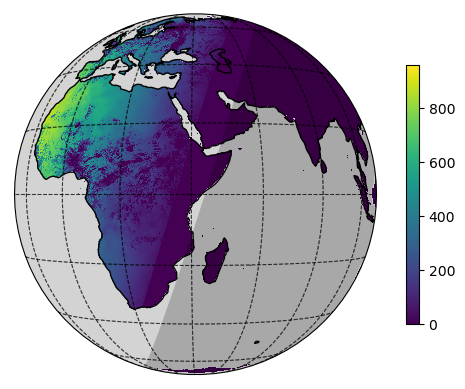

In [9]:
# Create a simple plot of the variable 

# to avoid showing warnings of cartopy
import warnings
warnings.filterwarnings('ignore')

data_crs = ccrs.Geostationary(central_longitude=central_longitude,satellite_height=36000*1000.)

ax = plt.axes(projection=data_crs, facecolor='white')
map_extend_geos = ax.get_extent(crs=data_crs)
map_extend_geos = [1.025*x for x in map_extend_geos] # needs this correction because image gets shifted
ax.coastlines()
ax.add_feature(cfeature.OCEAN, facecolor='lightgray')
ax.gridlines(color='black', alpha=0.5, linestyle='--', linewidth=0.75, draw_labels=False)
im1 = ax.imshow(zvar, interpolation='nearest',origin='upper',extent=map_extend_geos, )
cb = plt.colorbar(im1,shrink=0.7)
ax.add_feature(Nightshade(slot, alpha=0.2))
ax.gridlines(color='black', alpha=0.5, linestyle='--', linewidth=0.75, draw_labels=False)